In [224]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Bus Time (Actual, from Nathan Johnson)

All files are located under gdrive/Capstone/data/dummy-feb

In [13]:
fname = "bus_time_20150201.csv"

bt = pd.read_csv(fname)

In [44]:
bt.tail()

,timestamp,vehicle_id,latitude,longitude,bearing,progress,service_date,trip_id,block_assigned,next_stop_id,dist_along_route,dist_from_stop
2020649,2015-02-01T23:59:59Z,8004,40.752013,-73.760696,13.91,0,20150201,QV_A5-Sunday-111300_MISC_160,0,501621,7386.02,80.26
2020650,2015-02-01T23:59:59Z,8798,40.721489,-73.776643,114.55,0,20150201,JA_A5-Sunday-112300_Q17_11,1,501332,3727.21,266.93
2020651,2015-02-01T23:59:59Z,9021,40.680061,-73.905533,329.49,0,20150201,EN_A5-Sunday-112500_Q24_413,1,307156,2576.21,206.53
2020652,2015-02-01T23:59:59Z,9617,40.644505,-73.902982,138.15,0,20150201,UP_A5-Sunday-107100_B6_230,1,308003,12664.16,188.14
2020653,2015-02-01T23:59:59Z,9677,40.693621,-73.913274,330.52,0,20150201,GA_A5-Sunday-112500_B60_721,0,305048,4792.19,6.38


In [150]:
len(bt)

2020654

# Bus Schedule, also from Nathan Johnson

In [46]:
st = pd.read_table("./gtfs_20150103/stop_times.txt", sep=",")

In [79]:
st.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type
0,CA_A5-Saturday-001500_S4696_301,00:15:00,00:15:00,203386,1,0,0
1,CA_A5-Saturday-001500_S4696_301,00:15:55,00:15:55,203574,2,0,0
2,CA_A5-Saturday-001500_S4696_301,00:17:07,00:17:07,203387,3,0,0
3,CA_A5-Saturday-001500_S4696_301,00:17:37,00:17:37,203853,4,0,0
4,CA_A5-Saturday-001500_S4696_301,00:18:05,00:18:05,203830,5,0,0


In [246]:
print "number of records: " + str(len(st))
print "number of unique trips: " + str(len(st.trip_id.unique()))

number of records: 8855843
number of unique trips: 220344


## bus trip list

In [49]:
tr = pd.read_table("./gtfs_20150103/trips.txt", sep=",")

In [50]:
len(tr)

220344

In [51]:
tr.head()

,route_id,service_id,trip_id,trip_headsign,direction_id,shape_id
0,B11,JG_A5-Saturday,JG_A5-Saturday-025000_B11_1,MIDWOOD FLATBUSH AV,0,B110026
1,B11,JG_A5-Saturday,JG_A5-Saturday-028000_B11_2,MIDWOOD FLATBUSH AV,0,B110026
2,B11,JG_A5-Saturday,JG_A5-Saturday-029500_B11_1,SUNSET PARK 1 AV - 58 ST,1,B110025
3,B11,JG_A5-Saturday,JG_A5-Saturday-031000_B11_3,MIDWOOD FLATBUSH AV,0,B110026
4,B11,JG_A5-Saturday,JG_A5-Saturday-032500_B11_2,SUNSET PARK 1 AV - 58 ST,1,B110025


# Now let's merge them

In [169]:
# schedule
sched = st[['arrival_time','stop_id','trip_id']].copy()

In [247]:
sched.head()

,arrival_time,stop_id,trip_id
0,00:15:00,203386,CA_A5-Saturday-001500_S4696_301
1,00:15:55,203574,CA_A5-Saturday-001500_S4696_301
2,00:17:07,203387,CA_A5-Saturday-001500_S4696_301
3,00:17:37,203853,CA_A5-Saturday-001500_S4696_301
4,00:18:05,203830,CA_A5-Saturday-001500_S4696_301


In [170]:
# actual
def conv_float(x):
    try:
        return float(x)
    except:
        return np.nan
act = bt[["timestamp","next_stop_id","dist_from_stop","trip_id"]].copy()
act['dist_from_stop'] = act['dist_from_stop'].apply(lambda x: conv_float(x))
act.rename(columns={"next_stop_id":"stop_id"}, inplace=True)
act.stop_id = act.stop_id.apply(lambda s: int(s) if s.isdigit() else 0)

In [171]:
act.head()

,timestamp,stop_id,dist_from_stop,trip_id
0,2015-02-01T00:00:00Z,551742,13.00,7696804-CPPA5-CP_A5-Saturday-80
1,2015-02-01T00:00:00Z,308211,99.73,JG_A5-Saturday-106500_B63_118
2,2015-02-01T00:00:00Z,102375,24.92,WF_A5-Saturday-110000_BX36_151
3,2015-02-01T00:00:00Z,103899,5.81,WF_A5-Saturday-113100_BX15_28
4,2015-02-01T00:00:00Z,302682,91.08,JG_A5-Saturday-113000_B70_204


### Since the actual time is pinged every 30 seconds, I only pick records that have nearest distance to a bus stop, for each trip.

In [174]:
idx = act.groupby(['stop_id','trip_id'])['dist_from_stop'].transform(min) == act['dist_from_stop']
act = act[idx]

### Merge actual and schedule data by `trip_id` and `stop_id`

In [266]:
merged = pd.merge(act,sched, on=["stop_id","trip_id"])

In [267]:
len(merged)

957448

In [268]:
merged.head()

,timestamp,stop_id,dist_from_stop,trip_id,arrival_time
0,2015-02-01T00:00:00Z,103899,5.81,WF_A5-Saturday-113100_BX15_28,19:01:00
1,2015-02-01T00:00:00Z,302682,91.08,JG_A5-Saturday-113000_B70_204,19:00:41
2,2015-02-01T00:00:00Z,400240,136.48,MV_A5-Saturday-107600_M2_127,18:52:52
3,2015-02-01T00:00:00Z,403162,156.27,MV_A5-Saturday-110200_M104_36,18:50:47
4,2015-02-01T00:00:00Z,405427,64.31,KB_A5-Saturday-107500_M100_333,18:55:00


### for each record, calculate actual - schedule
- minus means the bus was ahead the schedule
- timestamp (actual arrival time) was in GMT so we have to convert to EST
- results are in seconds

In [269]:
def timediff(df):
    try:
        actual = datetime.datetime.strptime(df.timestamp, "%Y-%m-%dT%H:%M:%SZ")- datetime.timedelta(hours=5)
        actual_date = actual.strftime("%Y-%m-%d")
        schedule = datetime.datetime.strptime(actual_date+df.arrival_time, "%Y-%m-%d%H:%M:%S")
        if actual >= schedule:
            diff = (actual-schedule).seconds
        else:
            diff = (schedule-actual).seconds *-1
    except:
        diff = np.nan
    return diff
merged['delta']=merged.apply(timediff, axis=1)

In [203]:
#merged.to_csv('try_20150201.csv')

In [271]:
# the result
merged.tail()

,timestamp,stop_id,dist_from_stop,trip_id,arrival_time,delta
957443,2015-02-01T23:59:59Z,101402,14.45,WF_A5-Sunday-112300_BX21_31,18:58:09,110.0
957444,2015-02-01T23:59:59Z,501621,80.26,QV_A5-Sunday-111300_MISC_160,19:00:16,-17.0
957445,2015-02-01T23:59:59Z,307156,206.53,EN_A5-Sunday-112500_Q24_413,18:57:40,139.0
957446,2015-02-01T23:59:59Z,308003,188.14,UP_A5-Sunday-107100_B6_230,18:56:00,239.0
957447,2015-02-01T23:59:59Z,305048,6.38,GA_A5-Sunday-112500_B60_721,19:09:40,-581.0


In [272]:
# delete duplicated stop_id and trip_id
idx = merged.groupby(['stop_id','trip_id'])['delta'].transform(max) == merged['delta']
merged2 = merged[idx]

In [273]:
len(merged2)

800946

### histogram (for delta < 30 minutes and delta > -30 minutes)

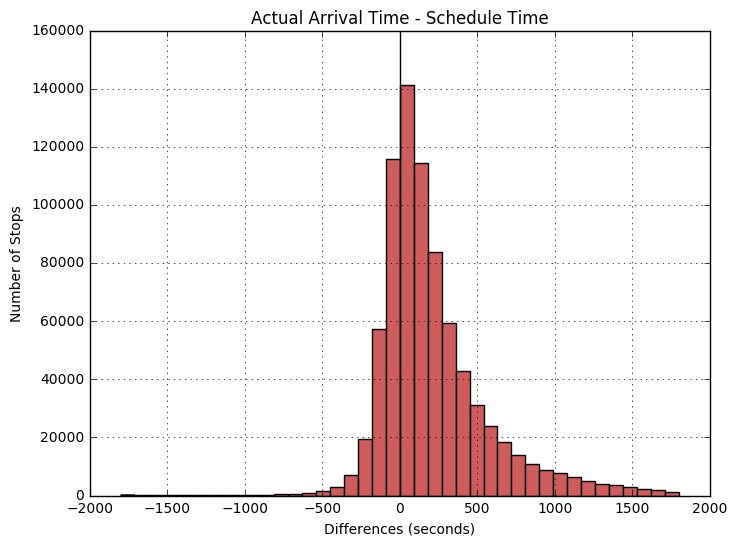

In [284]:
plt.figure(figsize=(8,6))
merged2[(merged2.delta<=1800)&(merged2.delta>-1800)]['delta'].hist(bins=40, color="IndianRed")
plt.title("Actual Arrival Time - Schedule Time")
plt.xlabel("Differences (seconds)")
plt.ylabel("Number of Stops")
plt.vlines(0, 0, 160000, )

In [295]:
print "mean of all deltas: " + str(merged2.delta.mean())
print "median of all deltas: " + str(merged2.delta.median())
print "standard deviation of all deltas: " + str(merged2.delta.std())
print "95 percentile: " + str(np.percentile(merged2.delta, 95))

mean of all deltas: 64.8758405685
median of all deltas: 127.0
standard deviation of all deltas: 3872.6668189
95 percentile: 1033.0
